In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ananthun","key":"29d038cbd85b91985b3bf6d0cdab5f7f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets list


401 - Unauthorized - Unauthenticated


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip -d data/


In [ ]:
!ls data/chest_xray


chest_xray  __MACOSX  test  train  val


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
train_dir = "data/chest_xray/train"
test_dir = "data/chest_xray/test"
val_dir = "data/chest_xray/val"



Normal X-rays:


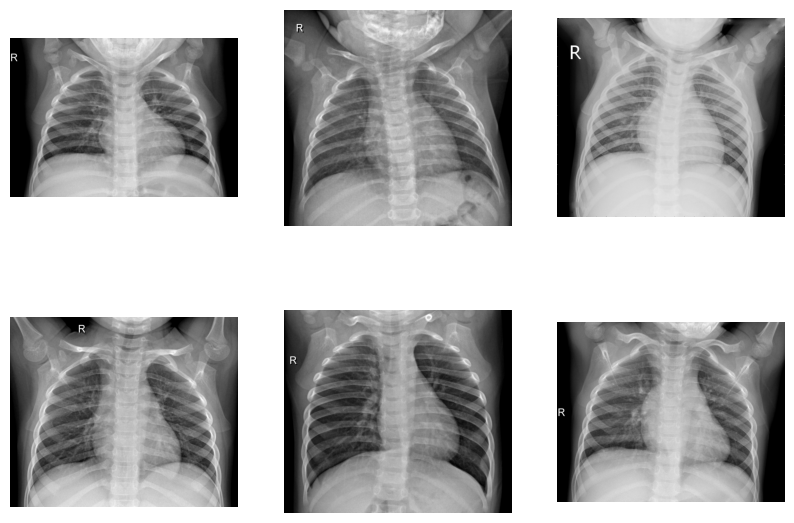

Pneumonia X-rays:


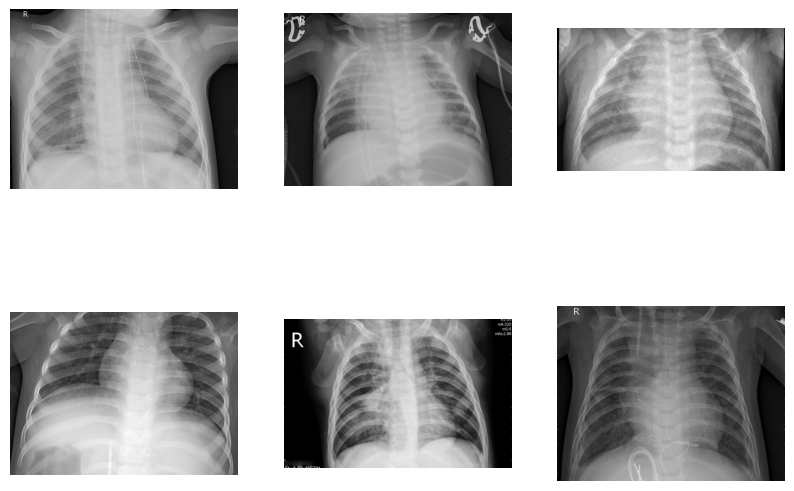

In [ ]:
def show_images(category, dataset='train'):
    folder = os.path.join(f"data/chest_xray/{dataset}", category)
    images = os.listdir(folder)[:6]  # Show first 6 images
    fig, ax = plt.subplots(2, 3, figsize=(10, 7))
    for i, img in enumerate(images):
        img_path = os.path.join(folder, img)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        ax[i // 3, i % 3].imshow(image, cmap='gray')
        ax[i // 3, i % 3].axis("off")
    plt.show()

print("Normal X-rays:")
show_images("NORMAL")

print("Pneumonia X-rays:")
show_images("PNEUMONIA")


In [ ]:
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


 Build the CNN Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary Classification (Normal vs Pneumonia)
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Train the Model

In [ ]:
EPOCHS = 5


history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    verbose=1
)


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 396ms/step - accuracy: 0.9605 - loss: 0.1008 - val_accuracy: 0.8125 - val_loss: 0.2906
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 393ms/step - accuracy: 0.9606 - loss: 0.1115 - val_accuracy: 0.8750 - val_loss: 0.2392
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 393ms/step - accuracy: 0.9606 - loss: 0.1081 - val_accuracy: 0.9375 - val_loss: 0.1728
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 399ms/step - accuracy: 0.9469 - loss: 0.1304 - val_accuracy: 0.9375 - val_loss: 0.2526
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 401ms/step - accuracy: 0.9591 - loss: 0.1091 - val_accuracy: 0.9375 - val_loss: 0.2383


 Evaluate the Model


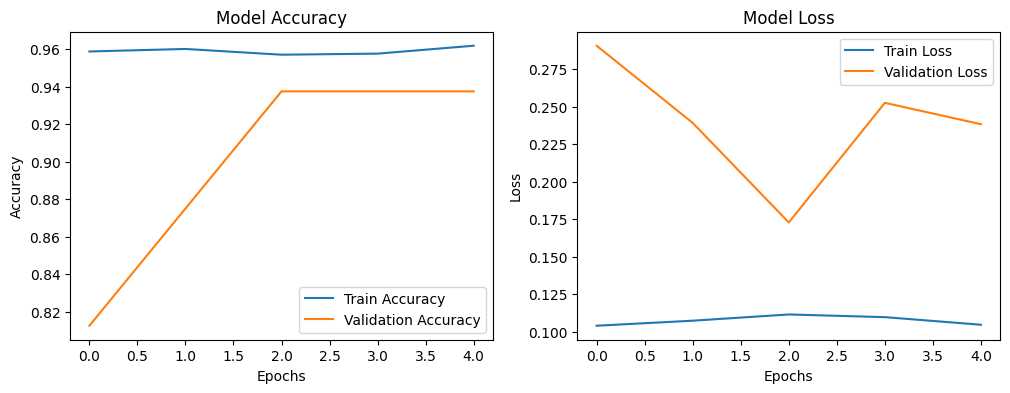

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

plt.show()


Evaluate on Test Data

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step - accuracy: 0.8547 - loss: 0.4020
Test Accuracy: 86.86%


In [ ]:
len(history.history['accuracy'])  # This will return the total number of epochs


50

Make Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


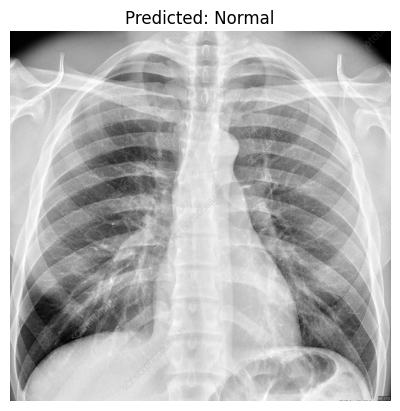

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


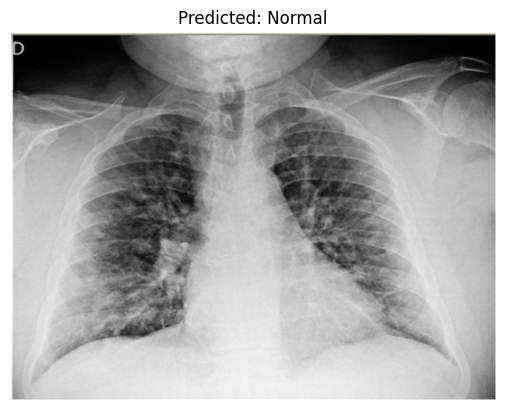

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


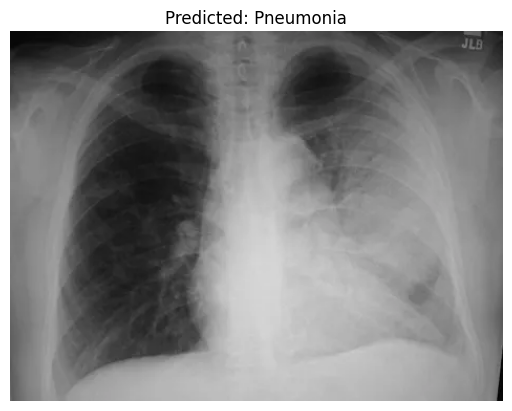

In [ ]:
import numpy as np

def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (150, 150)) / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    label = "Pneumonia" if prediction[0][0] > 0.5 else "Normal"

    plt.imshow(cv2.imread(image_path), cmap='gray')
    plt.title(f"Predicted: {label}")
    plt.axis("off")
    plt.show()

# Test on a sample pneumonia image
sample_img = "/content/800wm.jpeg"
sample_img1="/content/gr1.jpeg"
sample_img2="/content/xray1.webp"

predict_image(sample_img)
predict_image(sample_img1)
predict_image(sample_img2)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


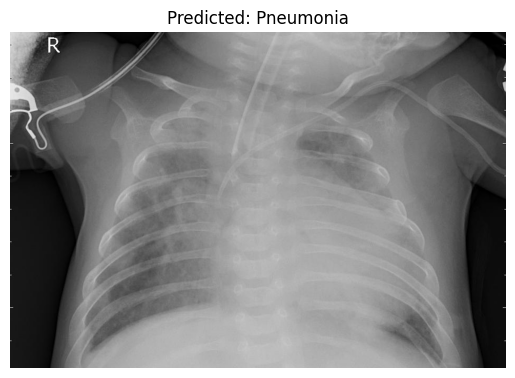

In [ ]:
import numpy as np

def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (150, 150)) / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    label = "Pneumonia" if prediction[0][0] > 0.5 else "Normal"

    plt.imshow(cv2.imread(image_path), cmap='gray')
    plt.title(f"Predicted: {label}")
    plt.axis("off")
    plt.show()

# Test on a sample pneumonia image
sample_img = "data/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg"
predict_image(sample_img)


Save & Export the Model

In [ ]:
import keras.saving
keras.saving.save_model(model, "pneumonia_detection_model.keras")
print("Model saved successfully!")


Model saved successfully!
